In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# wrangling
import pandas as pd
import numpy as np

# preparing
from sklearn.model_selection import train_test_split

# visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# exploring
import scipy.stats as stats
import pandas_profiling

# modeling
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression
from math import sqrt

# 3D projection
from mpl_toolkits.mplot3d import Axes3D

pd.options.display.float_format = '{:20,.2f}'.format

# my modules
import acquire
import summarize
import prepare

# default pandas decimal number display format
pd.options.display.float_format = '{:20,.2f}'.format

In [2]:
#df = acquire.get_zillow_data()

In [3]:
df = pd.read_csv("zillow_dataframe.csv")

In [4]:
df.head()

,Unnamed: 0,tax_rate,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,garagecarcnt,garagetotalsqft,latitude,longitude,...,poolcnt,poolsizesum,taxvaluedollarcnt,yearbuilt,landtaxvaluedollarcnt,taxdelinquencyflag,taxdelinquencyyear,logerror,transactions,county_name
0,0,0.01,3.50,4.00,"3,100.00","6,059.00",2.00,633.00,"33,634,931.00","-117,869,207.00",...,nan,nan,"1,023,282.00","1,998.00","537,569.00",NaN,nan,0.03,1,Orange
1,1,0.01,1.00,2.00,"1,465.00","6,111.00",1.00,0.00,"34,449,266.00","-119,281,531.00",...,nan,nan,"464,000.00","1,967.00","376,000.00",NaN,nan,0.06,1,Ventura
2,2,0.01,2.00,3.00,"1,243.00","6,059.00",2.00,440.00,"33,886,168.00","-117,823,170.00",...,1.00,nan,"564,778.00","1,962.00","479,489.00",NaN,nan,0.01,1,Orange
3,3,0.01,3.00,4.00,"2,376.00","6,037.00",nan,nan,"34,245,180.00","-118,240,722.00",...,1.00,nan,"145,143.00","1,970.00","36,225.00",NaN,nan,-0.10,1,Los Angeles
4,4,0.01,3.00,4.00,"2,962.00","6,037.00",nan,nan,"34,145,202.00","-118,179,824.00",...,1.00,nan,"773,303.00","1,950.00","496,619.00",NaN,nan,-0.00,1,Los Angeles


In [5]:
df = df.drop(columns=["Unnamed: 0", "garagetotalsqft", "poolsizesum", "taxdelinquencyflag", "taxdelinquencyyear", "transactions"])

- Read in 52,169 rows, 14 columns

In [6]:
df.shape

(52169, 15)

- Create county column from fips numbers and drop fips column

In [7]:
#df["county_name"] = df["fips"].map({6037: "Los Angeles", 6059: "Orange", 6111: "Ventura"})

In [8]:
#df.drop(columns="fips", inplace=True)

In [9]:
df.head()

,tax_rate,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,garagecarcnt,latitude,longitude,lotsizesquarefeet,poolcnt,taxvaluedollarcnt,yearbuilt,landtaxvaluedollarcnt,logerror,county_name
0,0.01,3.50,4.00,"3,100.00","6,059.00",2.00,"33,634,931.00","-117,869,207.00","4,506.00",nan,"1,023,282.00","1,998.00","537,569.00",0.03,Orange
1,0.01,1.00,2.00,"1,465.00","6,111.00",1.00,"34,449,266.00","-119,281,531.00","12,647.00",nan,"464,000.00","1,967.00","376,000.00",0.06,Ventura
2,0.01,2.00,3.00,"1,243.00","6,059.00",2.00,"33,886,168.00","-117,823,170.00","8,432.00",1.00,"564,778.00","1,962.00","479,489.00",0.01,Orange
3,0.01,3.00,4.00,"2,376.00","6,037.00",nan,"34,245,180.00","-118,240,722.00","13,038.00",1.00,"145,143.00","1,970.00","36,225.00",-0.10,Los Angeles
4,0.01,3.00,4.00,"2,962.00","6,037.00",nan,"34,145,202.00","-118,179,824.00","63,000.00",1.00,"773,303.00","1,950.00","496,619.00",-0.00,Los Angeles


### Split the data into train and test, 70/30

In [10]:
train, test = train_test_split(df, test_size=.30, random_state=123)

In [11]:
train.shape

(36518, 15)

In [12]:
test.shape

(15651, 15)

### Impute "poolcnt", "garagecarcnt" with 0s using a function.

 - Run this on train and test subsets separately

In [13]:
cols = ["poolcnt", "garagecarcnt"]

In [14]:
# Impute zeros into poolcnt and garagecarcnt on train set

train = prepare.fill_zero(train, cols=cols)

In [15]:
# Impute zeros into poolcnt and garagecarcnt on test set

test = prepare.fill_zero(test, cols=cols)

### Drop columns then rows using function

 - Run this on train and test subsets separately

In [16]:
# drop columns that have more than 50% of values missing and rows with more than 75% of values missing

train = prepare.handle_missing_values(train)

In [17]:
# drop columns that have more than 50% of values missing and rows with more than 75% of values missing

test = prepare.handle_missing_values(test)

### Drop the remaining Nulls in df to get clean train and test data sets

In [18]:
train.dropna(inplace=True)

In [19]:
test.dropna(inplace=True)

### THE train and test subsets with no missing values and poolcnt and garagecarcnt imputed with zeros. Outliers still in these subsets!

- I left county_name in these df for ease of exploration and viz. 

- Drop county_name and use fips for modeling and clustering purposes.

- If you want train and test with outliers handled, see below...

In [20]:
train.isnull().sum()

tax_rate                        0
bathroomcnt                     0
bedroomcnt                      0
calculatedfinishedsquarefeet    0
fips                            0
garagecarcnt                    0
latitude                        0
longitude                       0
lotsizesquarefeet               0
poolcnt                         0
taxvaluedollarcnt               0
yearbuilt                       0
landtaxvaluedollarcnt           0
logerror                        0
county_name                     0
dtype: int64

In [21]:
test.isnull().sum()

tax_rate                        0
bathroomcnt                     0
bedroomcnt                      0
calculatedfinishedsquarefeet    0
fips                            0
garagecarcnt                    0
latitude                        0
longitude                       0
lotsizesquarefeet               0
poolcnt                         0
taxvaluedollarcnt               0
yearbuilt                       0
landtaxvaluedollarcnt           0
logerror                        0
county_name                     0
dtype: int64

In [22]:
train.bedroomcnt.value_counts()

 3.00    16310
 4.00    10614
 2.00     5838
 5.00     2760
 6.00      451
 1.00      440
 7.00       75
 8.00       20
 9.00        6
10.00        2
14.00        1
12.00        1
Name: bedroomcnt, dtype: int64

In [23]:
train.bathroomcnt.value_counts()

 2.00    15260
 3.00     7474
 1.00     6627
 2.50     2804
 4.00     1571
 3.50      630
 1.50      578
 5.00      542
 4.50      482
 6.00      224
 5.50      160
 7.00       57
 8.00       40
 6.50       35
 7.50       14
 9.00       11
10.00        3
 8.50        2
11.00        2
18.00        1
13.00        1
Name: bathroomcnt, dtype: int64

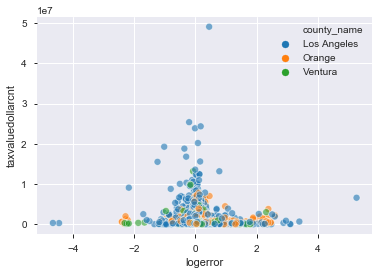

In [24]:
sns.scatterplot(data=train, x="logerror", y="taxvaluedollarcnt", hue="county_name", hue_order=["Los Angeles", "Orange", "Ventura"] , alpha=.6)

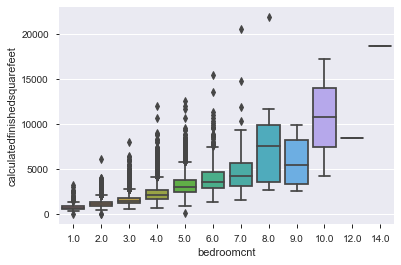

In [25]:
sns.boxplot(train.bedroomcnt, train.calculatedfinishedsquarefeet)

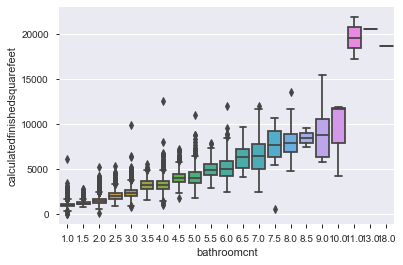

In [26]:
sns.boxplot(train.bathroomcnt, train.calculatedfinishedsquarefeet)

### Handle outliers by removing values < Q1 - IQR * 1.5 and values > Q3 + IQR * 1.5

In [27]:
train = prepare.remove_outliers_iqr(train, columns=["bedroomcnt", "bathroomcnt"], k=1.5)
train.shape

(34669, 15)

In [28]:
test = prepare.remove_outliers_iqr(test, columns=["bedroomcnt", "bathroomcnt"], k=1.5)
test.shape

(14874, 15)

### Convert dtypes to category for the cols below

- train_cat and test_cat are subsets with dtypes converted to category for the following columns:

    - "bathroomcnt", "bedroomcnt", "poolcnt", "yearbuilt", "garagecarcnt", "county_name"
    
- train_cat and test_cat also have outliers handled and no missing values.

In [29]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34669 entries, 22620 to 15725
Data columns (total 15 columns):
tax_rate                        34669 non-null float64
bathroomcnt                     34669 non-null float64
bedroomcnt                      34669 non-null float64
calculatedfinishedsquarefeet    34669 non-null float64
fips                            34669 non-null float64
garagecarcnt                    34669 non-null float64
latitude                        34669 non-null float64
longitude                       34669 non-null float64
lotsizesquarefeet               34669 non-null float64
poolcnt                         34669 non-null float64
taxvaluedollarcnt               34669 non-null float64
yearbuilt                       34669 non-null float64
landtaxvaluedollarcnt           34669 non-null float64
logerror                        34669 non-null float64
county_name                     34669 non-null object
dtypes: float64(14), object(1)
memory usage: 4.2+ MB


In [30]:
cols = ["bathroomcnt", "bedroomcnt", "poolcnt", "yearbuilt", "garagecarcnt", "county_name"]

In [31]:
train_cat = prepare.numeric_to_category(train, cols)

In [32]:
test_cat = prepare.numeric_to_category(test, cols)

In [33]:
train_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34669 entries, 22620 to 15725
Data columns (total 15 columns):
tax_rate                        34669 non-null float64
bathroomcnt                     34669 non-null category
bedroomcnt                      34669 non-null category
calculatedfinishedsquarefeet    34669 non-null float64
fips                            34669 non-null float64
garagecarcnt                    34669 non-null category
latitude                        34669 non-null float64
longitude                       34669 non-null float64
lotsizesquarefeet               34669 non-null float64
poolcnt                         34669 non-null category
taxvaluedollarcnt               34669 non-null float64
yearbuilt                       34669 non-null category
landtaxvaluedollarcnt           34669 non-null float64
logerror                        34669 non-null float64
county_name                     34669 non-null category
dtypes: category(6), float64(9)
memory usage: 2.9 MB


In [34]:
train.bedroomcnt.value_counts()

3.00    16270
4.00    10323
2.00     5836
5.00     2240
Name: bedroomcnt, dtype: int64

In [35]:
train.bathroomcnt.value_counts()

2.00    15180
3.00     7357
1.00     6237
2.50     2792
4.00     1458
3.50      616
1.50      577
4.50      452
Name: bathroomcnt, dtype: int64

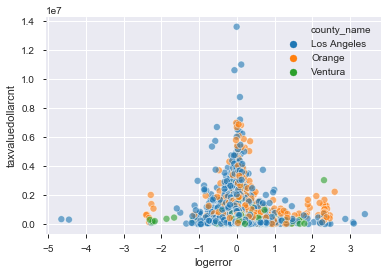

In [36]:
sns.scatterplot(data=train, x="logerror", y="taxvaluedollarcnt", hue="county_name", hue_order=["Los Angeles", "Orange", "Ventura"], alpha=.6)

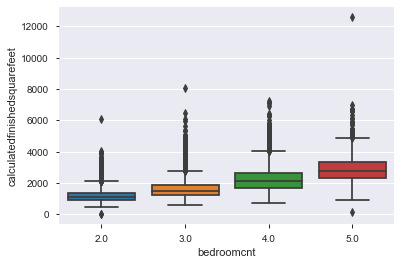

In [37]:
sns.boxplot(train.bedroomcnt, train.calculatedfinishedsquarefeet)

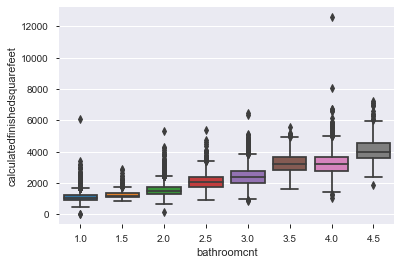

In [38]:
sns.boxplot(train.bathroomcnt, train.calculatedfinishedsquarefeet)

### Stats Testing to Decide on Feature Engineering

- Here I use a chi2 test to look at categorical features.

- $H_0$: Bathroomcnt is independent of how many bedrooms a home has.

- $H_a$: Bathroomcnt is not independent of how many bedrooms a home has.

In [39]:
# contingency_table from the df_cat dataframe (w/o categories)

contingency_table = pd.crosstab(train_cat.bedroomcnt, train_cat.bathroomcnt)
contingency_table

bathroomcnt,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5
bedroomcnt,,,,,,,,
2.00,3545,163,1776,146,187,10,9,0
3.00,2520,336,9347,1340,2300,140,262,25
4.00,151,77,3823,1177,3799,344,723,229
5.00,21,1,234,129,1071,122,464,198


In [40]:
_, p, _, expected = stats.chi2_contingency(contingency_table)

In [41]:
print(f"The p-value of the contingency test is {p}.")

The p-value of the contingency test is 0.0.


### Takeaways from chi2 test on bedroomcnt and bathroomcnt

- Based on the p_value of 0 from the chi2 test above, I reject the Null Hypothesis that bathroomcnt is independent of how many bedrooms a home has.


- Based on rejecting the Null Hypothesis, I will combine the two features into a single feature that is a ratio of bedrooms to bathrooms.

- $H_0$: garagecarcnt is independent of how many pools a home has.

- $H_a$: garagecarcnt is not independent of how many pools a home has.

In [45]:
contingency_table = pd.crosstab(train_cat.garagecarcnt, train_cat.poolcnt)
contingency_table

poolcnt,0.0,1.0
garagecarcnt,,
0.00,18405,4211
1.00,1304,158
2.00,7809,2286
3.00,176,176
4.00,49,66
5.00,6,9
6.00,4,3
7.00,2,0
8.00,0,1


In [46]:
_, p, _, expected = stats.chi2_contingency(contingency_table)

In [47]:
print(f"The p-value of the contingency test is {p}.")

The p-value of the contingency test is 6.195435621482677e-94.


### Takeaways from chi2 test on bedroomcnt and bathroomcnt

- Based on the p_value of 0 from the chi2 test above, I reject the Null Hypothesis that garagecarcnt is independent of how many pools a home has.


- Based on rejecting the Null Hypothesis, I would think about combining these two features into a single binary feature that identifies if a home has a pool or a garage.

-  Here I use Pearson r tests to identify linear correlations in variables for possible feature engineering.

In [50]:
r, p = stats.pearsonr(train_cat.lotsizesquarefeet, train_cat.taxvaluedollarcnt)

In [ ]:
print(f"")